In [1]:
#import torch
import os, sys, re, time
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
#import torch
print(os.getpid())
sys.path.append(r"/lab/weissman_imaging/puzheng/Softwares")

400828


In [2]:
import cv2
from ChromAn.src.file_io.data_organization import search_fovs_in_folders, Color_Usage
from ChromAn.src.segmentation_tools.cells import Align_Segmentation

In [3]:
import merlin
from merlin.util import watershed
from scipy import ndimage
from skimage import morphology
from skimage import segmentation
from copy import copy

In [4]:
# Cellpose 
from cellpose import models

## Folders

In [5]:
# data_folder
data_folder = r'/lab/weissman_imaging/puzheng/4T1Tumor/20240108-MF4_F171-4'
# correction
correction_folder = r'/lab/weissman_imaging/puzheng/Corrections/20230902-Merscope01_s30_n500'

segmentation_save_folder = os.path.join(data_folder, 'Segmentation')
if not os.path.exists(segmentation_save_folder):
    print(segmentation_save_folder)
    os.makedirs(segmentation_save_folder)
watershed_folder = os.path.join(segmentation_save_folder, 'watershed')
if not os.path.exists(watershed_folder):
    print(watershed_folder)
    os.makedirs(watershed_folder)

In [6]:
# transpose with microscope
parameter_folder = r'/lab/weissman_imaging/puzheng/Softwares/Weissman_MERFISH_Scripts/merlin_parameters'
microscope_file = os.path.join(parameter_folder, 'microscope', 'merscope01_microscope.json')
microscope_params = Align_Segmentation._read_microscope_json(microscope_file)
microscope_params

{'flip_horizontal': False,
 'flip_vertical': True,
 'transpose': True,
 'microns_per_pixel': 0.107,
 'image_dimensions': [2304, 2304]}

In [7]:
# search folders
folders, fovs = search_fovs_in_folders(data_folder)
# Color usage file marks the organization of imaging files
color_usage_filename = os.path.join(data_folder, 'Analysis', 'color_usage.csv')
color_usage_df = Color_Usage(color_usage_filename)

- searching in folder: /lab/weissman_imaging/puzheng/4T1Tumor/20240108-MF4_F171-4
-- 10 folders, 142 fovs detected.
- load color_usage from file: /lab/weissman_imaging/puzheng/4T1Tumor/20240108-MF4_F171-4/Analysis/color_usage.csv


In [8]:
# from color_usage, find dapi / polyt / fiducial
dapi_info = color_usage_df.get_dapi_info()[0]
polyt_info = color_usage_df.get_polyt_info()[0]
fiducial_channel = color_usage_df.get_fiducial_channel(color_usage_df)
print(dapi_info, polyt_info, fiducial_channel)

{'hyb': 'H0M1', 'channel': '405'} {'channel': '637', 'hyb': 'H8M9'} 477


In [10]:
from ChromAn.src.file_io.dax_process import DaxProcesser
from ChromAn.src.visual_tools.interactive import imshow_mark_3d
from merlin.analysis.segment import CellPoseSegment
from importlib import reload
import ChromAn
reload(ChromAn.src.file_io.dax_process)

<module 'ChromAn.src.file_io.dax_process' from '/lab/weissman_imaging/puzheng/Softwares/ChromAn/src/file_io/dax_process.py'>

# Run segmentation

In [15]:
overwrite = True
ref_idx = 0

for _fov_id, _fov_name in enumerate(fovs):

    _save_id = _fov_id 
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(seg_save_file) and not overwrite:
        print(f"Segmentation label file: {seg_save_file} already exists, skip")
        continue
    
    # find images
    ref_image_file = os.path.join(data_folder, color_usage_df.index[ref_idx], _fov_name)
    dapi_image_file = os.path.join(data_folder, dapi_info['hyb'], _fov_name)
    polyt_image_file = os.path.join(data_folder, polyt_info['hyb'], _fov_name)
    print(f"reference image: {ref_image_file}")
    print(f"PolyT image: {polyt_image_file}")
    print(f"DAPI image: {dapi_image_file}")
    
    # load reference DAPI
    _ref_cls = DaxProcesser(ref_image_file, CorrectionFolder=correction_folder, 
                            FiducialChannel=fiducial_channel, DapiChannel=dapi_info['channel'])
    _ref_cls._load_image(sel_channels=[fiducial_channel])
    _ref_cls._corr_illumination(correction_channels=[fiducial_channel])
    _ref_im = getattr(_ref_cls, f'im_{fiducial_channel}')

    # load dapi
    _dapi_cls = DaxProcesser(dapi_image_file, CorrectionFolder=correction_folder, 
                        FiducialChannel=fiducial_channel)
    _dapi_cls._load_image(sel_channels=[dapi_info['channel'],fiducial_channel])
    _dapi_cls.ref_correction_channel = '637'
    _dapi_cls._corr_illumination(correction_channels=[dapi_info['channel']])
    _dapi_cls._calculate_drift(_ref_im, )
    _dapi_cls._corr_warpping_drift_chromatic(correction_channels=[dapi_info['channel']], corr_chromatic=False) # removed 405 to increase efficiency
    _dapi_im = getattr(_dapi_cls, f"im_{dapi_info['channel']}")

    # load polyT
    _polyt_cls = DaxProcesser(polyt_image_file, CorrectionFolder=correction_folder, 
                        FiducialChannel=fiducial_channel)
    _polyt_cls._load_image(sel_channels=[polyt_info['channel'],fiducial_channel])
    _polyt_cls.ref_correction_channel = '637'
    _polyt_cls._corr_illumination(correction_channels=[polyt_info['channel']])
    _polyt_cls._calculate_drift(_ref_im, )
    _polyt_cls._corr_warpping_drift_chromatic(correction_channels=[polyt_info['channel']], corr_chromatic=False) # removed 405 to increase efficiency
    _polyt_im = getattr(_polyt_cls, f"im_{polyt_info['channel']}")
        
    # Run segmentation if target file not exist:
    if os.path.isfile(seg_save_file) and not overwrite:
        print(f"- directly load seg from: {seg_save_file}")
        corr_labels3d = np.load(seg_save_file)
    else:
        print(f"- apply microscope corrections")
        dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_dapi_im, microscope_params)
        polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_polyt_im, microscope_params)

        # Create cellpose model
        print(f"- run Cellpose segmentation", end=' ')
        _cellpose_start = time.time()
        seg_model = models.CellposeModel(gpu=True, model_type='tissuenet')
        # Run cellpose prediction
        labels3d, _, _ = seg_model.eval(np.stack([polyt_im, dapi_im], axis=3), 
                                        #batch_size=60, #anisotropy=250/108,
                                        anisotropy=1000/107,
                                        cellprob_threshold=0, 
                                        channels=[1,2], 
                                        diameter=70, 
                                        min_size=2000,
                                        do_3D=False,
                                        )
        print(f"in {time.time()-_cellpose_start:.3f}s.")

        # convert to corrected labels
        corr_labels3d = CellPoseSegment.combine_2d_segmentation_masks_into_3d(labels3d)
        #corr_labels3d = combine_2d_segmentation_masks_into_3d(labels3d)
        # save this segmentation mask
        #print(f"- save to file: {seg_save_file}")
        #np.save(seg_save_file.split('.npy')[0], corr_labels3d, )
    
    break

reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20240108-MF4_F171-4/H0M1/Conv_zscan_000.dax
PolyT image: /lab/weissman_imaging/puzheng/4T1Tumor/20240108-MF4_F171-4/H8M9/Conv_zscan_000.dax
DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20240108-MF4_F171-4/H0M1/Conv_zscan_000.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240108-MF4_F171-4/H0M1/Conv_zscan_000.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240108-MF4_F171-4/H0M1/Conv_zscan_000_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477'] in 0.320s.
- Correct illumination for channels: ['477']
-- Keep channels: ['477'] for corr_illumination.
- Start illumination correction for channels:['477'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 477 in 0.935s.
- Finished illumination correction in 0.9

<IPython.core.display.Javascript object>


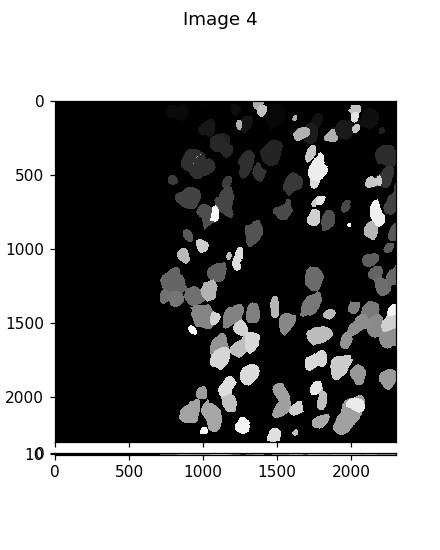

In [16]:
%matplotlib notebook
imshow_mark_3d([dapi_im, polyt_im, labels3d, corr_labels3d])

<IPython.core.display.Javascript object>


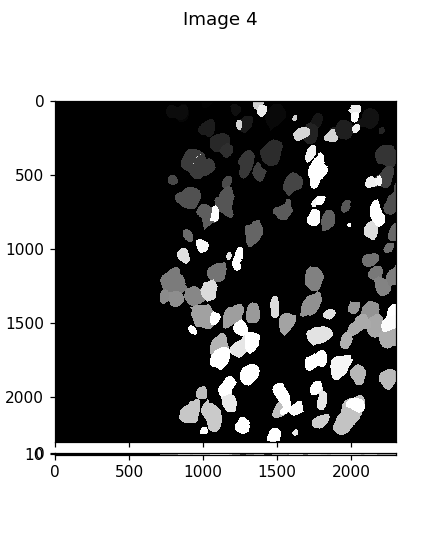

In [14]:
%matplotlib notebook
imshow_mark_3d([dapi_im, polyt_im, labels3d, corr_labels3d])

In [12]:
from typing import List, Dict, Tuple
def get_overlapping_objects(segmentationZ0: np.ndarray,
                            segmentationZ1: np.ndarray,
                            n0: int,
                            fraction_threshold0: float=0.2,
                            fraction_threshold1: float=0.2) -> Tuple[np.float64, 
                                              np.float64, np.float64]:
    """compare cell labels in adjacent image masks
    Args:
        segmentationZ0: a 2 dimensional numpy array containing a
            segmentation mask in position Z
        segmentationZ1: a 2 dimensional numpy array containing a
            segmentation mask adjacent to segmentationZ0
        n0: an integer with the index of the object (cell/nuclei)
            to be compared between the provided segmentation masks
    Returns:
        a tuple (n1, f0, f1) containing the label of the cell in Z1
        overlapping n0 (n1), the fraction of n0 overlaping n1 (f0) and
        the fraction of n1 overlapping n0 (f1)
    """

    z1Indexes = np.unique(segmentationZ1[segmentationZ0 == n0])

    z1Indexes = z1Indexes[z1Indexes > 0]

    if z1Indexes.shape[0] > 0:

        # calculate overlap fraction
        n0Area = np.count_nonzero(segmentationZ0 == n0)
        n1Area = np.zeros(len(z1Indexes))
        overlapArea = np.zeros(len(z1Indexes))

        for ii in range(len(z1Indexes)):
            n1 = z1Indexes[ii]
            n1Area[ii] = np.count_nonzero(segmentationZ1 == n1)
            overlapArea[ii] = np.count_nonzero((segmentationZ0 == n0) *
                                               (segmentationZ1 == n1))

        n0OverlapFraction = np.asarray(overlapArea / n0Area)
        n1OverlapFraction = np.asarray(overlapArea / n1Area)
        index = list(range(len(n0OverlapFraction)))

        # select the nuclei that has the highest fraction in n0 and n1
        r1, r2, indexSorted = zip(*sorted(zip(n0OverlapFraction,
                                              n1OverlapFraction,
                                              index),
                                  key=lambda x:x[0]+x[1],
                                  reverse=True))

        if (n0OverlapFraction[indexSorted[0]] > fraction_threshold0 and
                n1OverlapFraction[indexSorted[0]] > fraction_threshold1):
            return (z1Indexes[indexSorted[0]],
                    n0OverlapFraction[indexSorted[0]],
                    n1OverlapFraction[indexSorted[0]])
        else:
            return (False, False, False)
    else:
        return (False, False, False)

def combine_2d_segmentation_masks_into_3d(segmentationOutput: np.ndarray,
                                          minKept_zLen:int=2,
                                          matching_overlapRatio:float=0.33,
                                          ) -> np.ndarray:
    """Take a 3 dimensional segmentation masks and relabel them so that
    nuclei in adjacent sections have the same label if the area their
    overlap surpases certain threshold
    Args:
        segmentationOutput: a 3 dimensional numpy array containing the
            segmentation masks arranged as (z, x, y).
        minKept_zLen: minimum z-length of kept segmentation masks
        matching_overlapRatio: miminum overlap ratio bewteen two segmentation masks to be merged.
    Returns:
        ndarray containing a 3 dimensional mask arranged as (z, x, y) of
            relabeled segmented cells
    """

    # Initialize empty array with size as segmentationOutput array
    segmentationCombinedZ = np.zeros(segmentationOutput.shape, dtype=segmentationOutput.dtype)

    # copy the mask of the section farthest to the coverslip to start
    segmentationCombinedZ[-1, :, :] = segmentationOutput[-1, :, :]
    
    # Edit by Pu Zheng: start the seed at the middle z-plane, because usually that is the focal plane:
    mid_z = int(segmentationCombinedZ.shape[0]/2)
    # get the mid plane:
    # copy the mask of the section farthest to the coverslip to start
    segmentationCombinedZ[mid_z, :, :] = segmentationOutput[mid_z, :, :]
    zs = np.arange(0, segmentationCombinedZ.shape[0])
    zs_2_ref = np.abs(zs - (mid_z- 0.01)) # a trick to make mid-z closest to ref
    zs_sorted = zs[np.argsort(zs_2_ref)]
    processed_zs = [mid_z]
    for _iz, _z in enumerate(zs_sorted):
        if _iz == 0:
            continue
        # get ref_z
        _ref_z = processed_zs[np.argmin(np.abs(np.array(processed_zs)-_z))]#zs_sorted[_iz - 1]
        #
        # get non-background cell indexes for plane Z
        zIndex = np.unique(segmentationOutput[_z, :, :])[
                           np.unique(segmentationOutput[_z, :, :]) > 0]
        # attach _z to _ref_z
        # get non-background cell indexes for plane Z-1
        refzIndex = np.unique(segmentationCombinedZ[_ref_z, :, :])[
                              np.unique(segmentationCombinedZ[_ref_z, :, :]) > 0]
        # record assigned index
        assigned_refzIndex = []
        print(_z, _ref_z)
        print(len(zIndex))
        # compare each cell in z0
        for n0 in refzIndex:
            n1, f0, f1 = get_overlapping_objects(segmentationCombinedZ[_ref_z, :, :],
                                                 segmentationOutput[_z, :, :],
                                                 n0, 
                                                 fraction_threshold0=matching_overlapRatio,
                                                 fraction_threshold1=matching_overlapRatio,)
            # If matched: merge
            if n1:
                segmentationCombinedZ[_z, :, :][
                    (segmentationOutput[_z, :, :] == n1)] = n0
                assigned_refzIndex.append(n1)
            # If not matched: copy next layer
            else:
                segmentationCombinedZ[_z, :, :][
                    (segmentationCombinedZ[_ref_z, :, :] == n0)] = n0
                #assigned_refzIndex.append(n1)
                
        # keep the un-assigned indices in the Z-1 plane
        unassigned_refzIndex = [i for i in refzIndex if i not in assigned_refzIndex]
        max_current_id = np.max(segmentationCombinedZ[_z:, :, :])
        for i in range(len(unassigned_refzIndex)):
            unassigned_id = unassigned_refzIndex[i]
            segmentationCombinedZ[_z, :, :][
                    (segmentationOutput[_z, :, :] == unassigned_id)] = max_current_id + 1 +i
        
        processed_zs.append(_z)
        print(processed_zs)
        
    # remove label with only 1 z-layer
    segmentationCleanedZ = np.zeros(segmentationOutput.shape, dtype=np.int16)
    for _lb in np.arange(1, np.max(segmentationCombinedZ)+1):
        _cellMask = (segmentationCombinedZ==_lb)
        _cell_zIndex = np.where(_cellMask.any((1,2)))[0]
        #print(_cell_zIndex)
        if len(_cell_zIndex) < minKept_zLen:
            continue
        else:
            segmentationCleanedZ[segmentationCombinedZ==_lb] = np.max(segmentationCleanedZ) + 1
                
    return segmentationCleanedZ

In [104]:
merged_labels3d = combine_2d_segmentation_masks_into_3d(labels3d)

5 6
105
[6, 5]
7 6
98
[6, 5, 7]
4 5
105
[6, 5, 7, 4]
8 7
90
[6, 5, 7, 4, 8]
3 4
105
[6, 5, 7, 4, 8, 3]
9 8
85
[6, 5, 7, 4, 8, 3, 9]
2 3
100
[6, 5, 7, 4, 8, 3, 9, 2]
10 9
76
[6, 5, 7, 4, 8, 3, 9, 2, 10]
1 2
93
[6, 5, 7, 4, 8, 3, 9, 2, 10, 1]
11 10
66
[6, 5, 7, 4, 8, 3, 9, 2, 10, 1, 11]
0 1
81
[6, 5, 7, 4, 8, 3, 9, 2, 10, 1, 11, 0]
12 11
64
[6, 5, 7, 4, 8, 3, 9, 2, 10, 1, 11, 0, 12]


In [84]:
from merlin.analysis.segment import CellPoseSegment

In [88]:
%%time
combined_labels_3d = CellPoseSegment.combine_2d_segmentation_masks_into_3d(labels3d)

CPU times: user 32 s, sys: 275 ms, total: 32.3 s
Wall time: 32.2 s


<IPython.core.display.Javascript object>


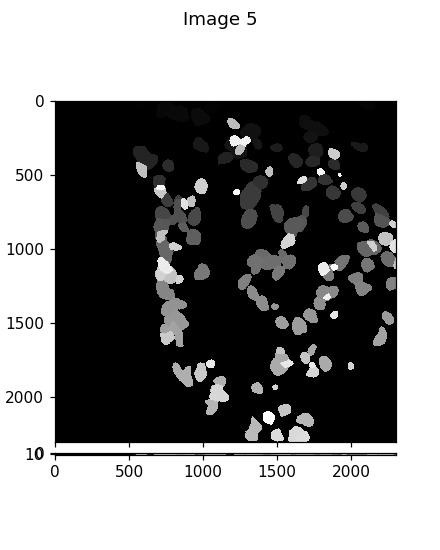

In [105]:
imshow_mark_3d([dapi_im, polyt_im, labels3d, corr_labels3d, merged_labels3d])

In [ ]:
imshow_mark_3d([_dapi_im, _polyt_im, labels3d, combined_labels_3d])

<IPython.core.display.Javascript object>


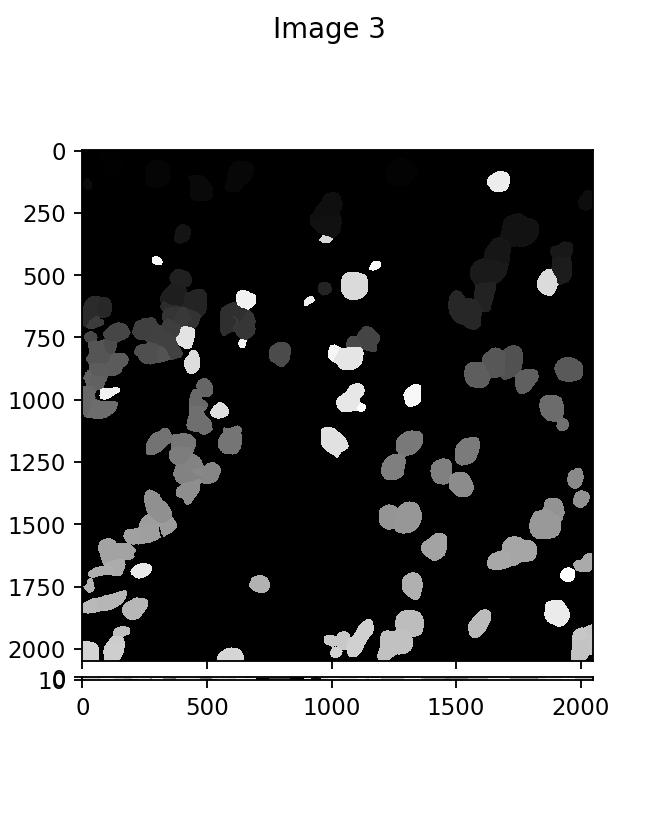

In [24]:
%matplotlib notebook
imshow_mark_3d([polyt_im, dapi_im, corr_labels3d])

# STEP2: Watershed: Optional, potentially make it worse

In [15]:
watershed_th = 1.6
ref_idx = 0

for _fov_id, _fov_name in enumerate(fovs):
    

    _save_id = _fov_id 
    
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    watershed_save_file = os.path.join(watershed_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(watershed_save_file):
        print(f"{watershed_save_file} already exists, skip")
        continue
    # Load segmentation
    if os.path.isfile(seg_save_file):
        print(f"- directly load seg from: {seg_save_file}")
        corr_labels3d = np.load(seg_save_file)
    else:
        print(f"- seg file: {seg_save_file} has not been generated yet, skip. ")
        continue
        
    # find images
    ref_image_file = os.path.join(data_folder, color_usage_df.index[ref_idx], _fov_name)
    dapi_image_file = os.path.join(data_folder, dapi_info['hyb'], _fov_name)
    polyt_image_file = os.path.join(data_folder, polyt_info['hyb'], _fov_name)
    print(f"reference image: {ref_image_file}")
    print(f"PolyT image: {polyt_image_file}")
    print(f"DAPI image: {dapi_image_file}")
    # load reference DAPI
    _ref_cls = DaxProcesser(ref_image_file, CorrectionFolder=correction_folder, 
                            FiducialChannel=fiducial_channel, DapiChannel=dapi_info['channel'])
    _ref_cls._load_image(sel_channels=[fiducial_channel])
    _ref_cls._corr_illumination(correction_channels=[fiducial_channel])
    _ref_im = getattr(_ref_cls, f'im_{fiducial_channel}')

    # load dapi
    _dapi_cls = DaxProcesser(dapi_image_file, CorrectionFolder=correction_folder, 
                        FiducialChannel=fiducial_channel)
    _dapi_cls._load_image(sel_channels=[dapi_info['channel'],fiducial_channel])
    _dapi_cls.ref_correction_channel = '637'
    _dapi_cls._corr_illumination(correction_channels=[dapi_info['channel']])
    _dapi_cls._calculate_drift(_ref_im, )
    _dapi_cls._corr_warpping_drift_chromatic(correction_channels=[dapi_info['channel']], corr_chromatic=False) # removed 405 to increase efficiency
    _dapi_im = getattr(_dapi_cls, f"im_{dapi_info['channel']}")

    # load polyT
    _polyt_cls = DaxProcesser(polyt_image_file, CorrectionFolder=correction_folder, 
                        FiducialChannel=fiducial_channel)
    _polyt_cls._load_image(sel_channels=[polyt_info['channel'],fiducial_channel])
    _polyt_cls.ref_correction_channel = '637'
    _polyt_cls._corr_illumination(correction_channels=[polyt_info['channel']])
    _polyt_cls._calculate_drift(_ref_im, )
    _polyt_cls._corr_warpping_drift_chromatic(correction_channels=[polyt_info['channel']], corr_chromatic=False) # removed 405 to increase efficiency
    _polyt_im = getattr(_polyt_cls, f"im_{polyt_info['channel']}")
    
    
    _save_id = _fov_id 

    dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_dapi_im, microscope_params)
    polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_polyt_im, microscope_params)

    # Prepare watershed
    print(f"- run watershed", end=' ')
    _watershed_start = time.time()
    water_input_im = polyt_im
    waterIm, waterMask = watershed.prepare_watershed_images(water_input_im, watershed_th)
    waterMask[corr_labels3d > 0] = True
    waterMask = ndimage.binary_dilation(waterMask, structure=morphology.ball(1))
    # watershed
    new_labels = segmentation.watershed(
                    waterIm, corr_labels3d, mask=waterMask,
                    connectivity=np.ones((3, 3, 3)), watershed_line=True)
    print(f"in {time.time()-_watershed_start:.3f}s.")

    # save
    # save this segmentation mask
    print(f"- save to file: {watershed_save_file}")
    np.save(watershed_save_file.split('.npy')[0], new_labels, )
    
    break

- directly load seg from: /lab/weissman_imaging/puzheng/4T1Tumor/20231222-4T1tumor_F170_MF4/Segmentation/segmentation_label_0.npy
reference image: /lab/weissman_imaging/puzheng/4T1Tumor/20231222-4T1tumor_F170_MF4/H0M1/Conv_zscan_000.dax
PolyT image: /lab/weissman_imaging/puzheng/4T1Tumor/20231222-4T1tumor_F170_MF4/H8M9/Conv_zscan_000.dax
DAPI image: /lab/weissman_imaging/puzheng/4T1Tumor/20231222-4T1tumor_F170_MF4/H0M1/Conv_zscan_000.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20231222-4T1tumor_F170_MF4/H0M1/Conv_zscan_000.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20231222-4T1tumor_F170_MF4/H0M1/Conv_zscan_000_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477'] in 0.398s.
- Correct illumination for channels: ['477']
-- Keep channels: ['477'] for corr_illumination.
- Start illumination correction for channels:['477'].
-- loading illumination correct

<IPython.core.display.Javascript object>


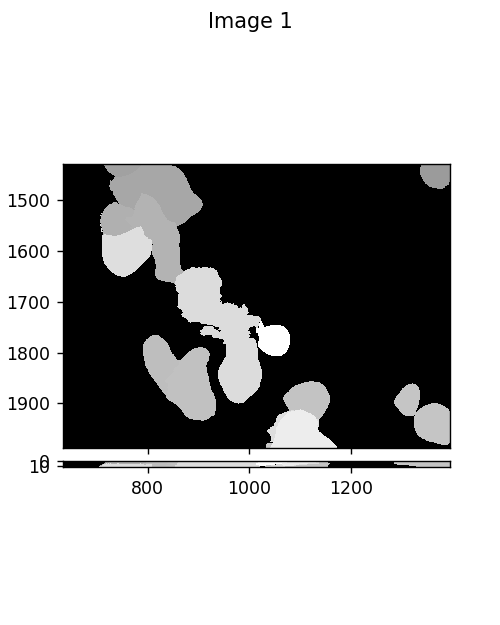

In [17]:
%matplotlib notebook
imshow_mark_3d([new_labels, corr_labels3d])

## visualize merlin_output_tif

In [12]:
import tifffile
ims = tifffile.imread(r'Z:\MERFISH_analysis\20230513-wtBrain_MO4\FiducialCorrelationWarp\images\aligned_fiducial_images30.tif')